In [92]:
import os, pickle
from collections import Counter
from tqdm import tqdm

root = os.path.join('data', 'output', 'round_12','self_play')
tournamentfiles = [f for f in os.listdir(root) if f.startswith('tmnt_') and f.endswith('.pkl')]
agent0_points = []
agent1_points = []
checkmates = []

for file in tournamentfiles:
    with open(os.path.join(root, file), 'rb') as pkl:
        tourn = pickle.load(pkl)
    
    for i, pair in tourn.items():
        agent0_points.append(pair['a0wa1b']['white']['points'])
        agent1_points.append(pair['a0wa1b']['black']['points'])
        agent0_points.append(pair['a1wa0b']['black']['points'])
        agent1_points.append(pair['a1wa0b']['white']['points'])
        for order,game in pair.items():
            for color in game:
                if abs(game[color]['points']) == 1:
                    token, board = game[color]['moves'][-1]
                    points = game[color]['points']
                    checkmates.append((token, board, points))

print(f'{len(checkmates)/2:.0f} games ended in checkmate out of {len(tournamentfiles)*2:.0f} games played.')
Counter(agent0_points)

7 games ended in checkmate out of 8 games played.


Counter({1.0: 7, 0.0: 1})

In [4]:
# from chess_model import ChessDataset
# root_dir = os.path.join('data', 'output')
# dataset = ChessDataset(root_dir=root_dir, look_back=10, device=None)
# len(dataset)

#### How shall we test whether a newer model is better than an older model? 
Play them against each other until the estimated probability of a win by the newer model has high confidence (narrow distribution).

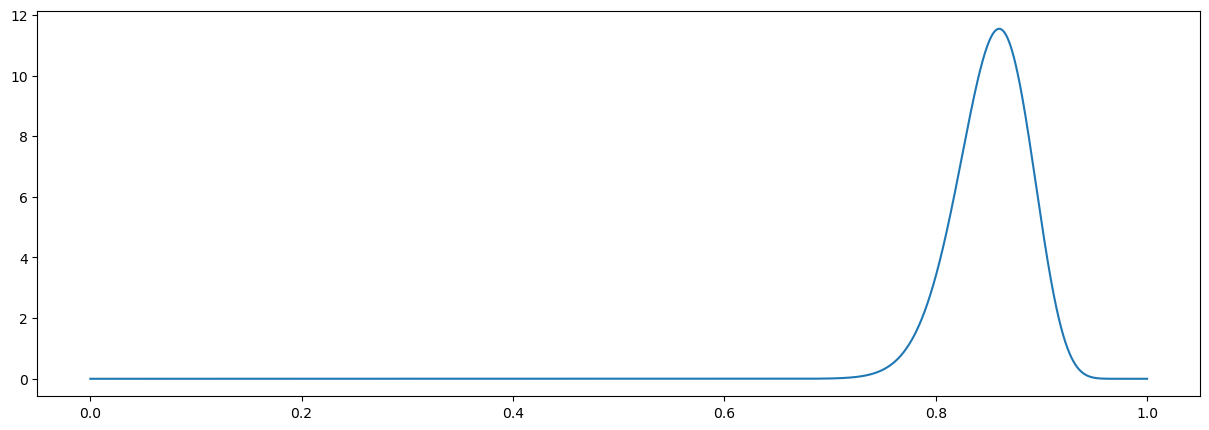

In [103]:
from math import factorial as fact
import matplotlib.pyplot as plt
trials = np.random.choice([-1,0,1], size=100, p=[0.05, 0.05, 0.9])

def likelihood(trials, n_points=100):
    num_wins = sum([i==1 for i in trials])
    num_loss = len(trials) - num_wins
    coef = fact(len(trials)+1)/(fact(num_wins)*fact(num_loss))
    R = np.linspace(0,1,n_points)
    pdf = [coef*(r**num_wins)*(1-r)**(num_loss) for r in R]
    return R, pdf

R, pdf = likelihood(trials, n_points=5000)

fig = plt.figure(figsize=(15,5))
plt.plot(R, pdf)

In [ ]:
import os, pickle
from collections import Counter
from tqdm import tqdm

source = os.path.join('data', 'output', 'old_round_0','self_play')
dest = os.path.join('data','output','new_round_0','self_play')
tournamentfiles = [f for f in os.listdir(source) if f.startswith('tmnt_') and f.endswith('.pkl')]

for file in tqdm(tournamentfiles):

    with open(os.path.join(source, file), 'rb') as pkl:
        old_tourn = pickle.load(pkl)

    new_tourn = {
        pair: {
            'a0wa1b': {
                'white': {
                    'points': old_tourn[pair][0]['white']['points'], 
                    'moves': old_tourn[pair][0]['white']['moves']
                }, 
                'black': {
                    'points': old_tourn[pair][0]['black']['points'], 
                    'moves': old_tourn[pair][0]['black']['moves']
                }
            },
            'a1wa0b': {
                'white': {
                    'points': old_tourn[pair][1]['white']['points'], 
                    'moves': old_tourn[pair][1]['white']['moves']
                }, 
                'black': {
                    'points': old_tourn[pair][1]['black']['points'], 
                    'moves': old_tourn[pair][1]['black']['moves']
                }
            }
        } for pair in old_tourn
    }

    with open(os.path.join(dest, file), 'wb') as pkl:
        pickle.dump(new_tourn, pkl)

In [10]:
import os, pickle
from collections import Counter
from tqdm import tqdm
root = os.path.join('data', 'output', 'round_10','self_play')
chkm_dest = os.path.join('data', 'output', 'checkmates','baseline')

tournamentfiles = [f for f in os.listdir(root) if f.startswith('tmnt_') and f.endswith('.pkl')]
supplementary_checkmates = os.listdir(chkm_dest)
positions = dict()

for file in tournamentfiles:
    with open(os.path.join(root, file), 'rb') as pkl:
        tourn = pickle.load(pkl)

    for i, pair in tourn.items():
        for order,game in pair.items():
            for color in game:
                points = game[color]['points']
                for token, move in game[color]['moves']:
                    token, board = game[color]['moves'][-1]
                    if token in positions:
                        positions[token]['visits'] += 1
                        positions[token]['points'] += points
                    else:
                        positions[token] = {'board':board, 'visits':1, 'points':points}

for file in supplementary_checkmates:
    with open(os.path.join(chkm_dest, file), 'rb') as pkl:
        token, board, points = pickle.load(pkl)
    if token not in positions:
        positions[token] = {'board':board, 'visits':1, 'points':points}

print(len(positions))
    

2191


(array([ 405.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1786.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

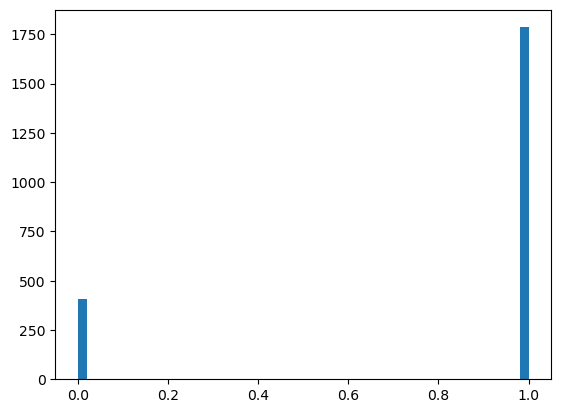

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.array([abs(position['points']/position['visits']) for position in positions.values()]), bins=50)

Text(0.5, 0, 'Number of moves made')

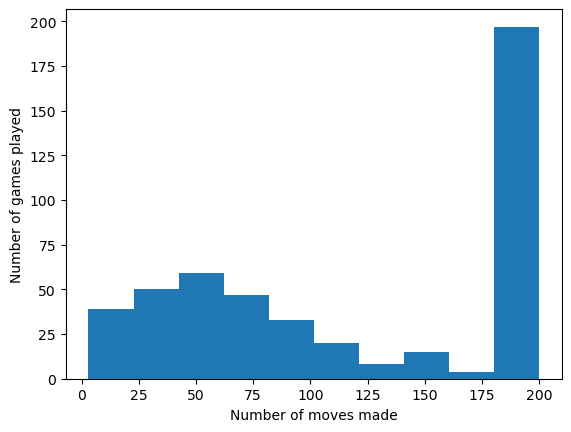

In [12]:
num_moves = []
for file in tournamentfiles:
    with open(os.path.join(root, file), 'rb') as pkl:
        tourn = pickle.load(pkl)

    for i, pair in tourn.items():
        for order,game in pair.items():
            nmoves = max(len(game['white']['moves']), len(game['black']['moves']))
            num_moves.append(nmoves)

plt.hist(num_moves)
plt.ylabel('Number of games played')
plt.xlabel('Number of moves made')
